In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Định nghĩa tên các cột theo tài liệu UCI
columns = [
    "Pregnancies",            # Số lần mang thai
    "Glucose",                # Nồng độ glucose huyết tương
    "BloodPressure",          # Huyết áp tâm trương
    "SkinThickness",          # Độ dày nếp gấp da (mm)
    "Insulin",                # Insulin huyết thanh (mu U/ml)
    "BMI",                    # Chỉ số khối cơ thể
    "DiabetesPedigreeFunction", # Hàm phả hệ tiểu đường (yếu tố di truyền)
    "Age",                    # Tuổi
    "Outcome"                 # Kết quả (0: Không mắc, 1: Mắc tiểu đường)
]
# Đọc dataset Pima Indians Diabetes
df = pd.read_csv("pima-indians-diabetes.csv", header=None, names=columns)

In [8]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [10]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [53]:
# NGƯỠNG RỘNG ĐỂ BẢO TOÀN DỮ LIỆU - CHỈ LỌC GIÁ TRỊ VÔ LÝ THỰC SỰ
physiological_ranges = {
    'Pregnancies': (0, 20),           # Số lần mang thai hợp lý
    'Glucose': (20, 300),             # Cho phép cả giá trị bệnh lý cao
    'BloodPressure': (40, 200),       # Bao gồm cả tăng huyết áp nặng
    'BMI': (10, 80),                  # Bao gồm cả béo phì bệnh lý
    'Age': (21, 100)                  # Tuổi hợp lý cho nghiên cứu
     # Với các chỉ số khác, có thể chỉ xử lý giá trị 0
}

In [54]:
def detect_physiological_errors(df, ranges):
    """Phát hiện dữ liệu ngoài ngưỡng sinh lý"""
    errors = {}
    
    for column, (min_val, max_val) in ranges.items():
        # Tìm các giá trị ngoài ngưỡng
        out_of_range = (df[column] < min_val) | (df[column] > max_val)
        error_count = out_of_range.sum()
        
        if error_count > 0:
            errors[column] = {
                'count': error_count,
                'min_actual': df[column].min(),
                'max_actual': df[column].max(),
                'problem_values': df[column][out_of_range].unique()
            }
    
    return errors

# Phát hiện lỗi
errors = detect_physiological_errors(df, physiological_ranges)
print("=== DỮ LIỆU LỖI PHÁT HIỆN ===")
for col, info in errors.items():
    print(f"{col}: {info['count']} giá trị lỗi")
    print(f"  - Range thực tế: {info['min_actual']} - {info['max_actual']}")
    print(f"  - Giá trị có vấn đề: {info['problem_values']}")

=== DỮ LIỆU LỖI PHÁT HIỆN ===
Glucose: 5 giá trị lỗi
  - Range thực tế: 0 - 199
  - Giá trị có vấn đề: [0]
BloodPressure: 39 giá trị lỗi
  - Range thực tế: 0 - 122
  - Giá trị có vấn đề: [ 0 30 24 38]
BMI: 11 giá trị lỗi
  - Range thực tế: 0.0 - 67.1
  - Giá trị có vấn đề: [0.]


In [55]:
# Chiến lược: XÓA các dòng có dữ liệu lỗi nghiêm trọng
def clean_physiological_errors(df, ranges):
    """Xóa dòng có dữ liệu ngoài ngưỡng sinh lý"""
    
    # Tạo mask để đánh dấu dòng lỗi
    error_mask = pd.Series(False, index=df.index)
    
    # Các chỉ số QUAN TRỌNG cần xử lý nghiêm ngặt
    critical_columns = ['Glucose', 'BloodPressure', 'BMI', 'Age']
    
    for column in critical_columns:
        min_val, max_val = ranges[column]
        # Đánh dấu dòng có giá trị ngoài ngưỡng
        error_mask |= (df[column] < min_val) | (df[column] > max_val)
    
    print(f"Số dòng có dữ liệu lỗi nghiêm trọng: {error_mask.sum()}")
    
    # Giữ lại các dòng KHÔNG có lỗi
    df_clean = df[~error_mask].copy()
    
    return df_clean

# Xử lý dữ liệu lỗi
df_clean = clean_physiological_errors(df, physiological_ranges)

Số dòng có dữ liệu lỗi nghiêm trọng: 48


In [56]:
# Sau khi xử lý lỗi nghiêm trọng, xử lý giá trị 0
def handle_zero_values(df):
    """Xử lý giá trị 0 bất thường trong các chỉ số sinh học"""
    
    # Các cột không được phép có giá trị 0
    zero_sensitive_columns = ['Glucose', 'BloodPressure','Insulin', 'BMI', 'SkinThickness']
    
    for col in zero_sensitive_columns:
        zero_mask = df[col] == 0
        if zero_mask.any():
            print(f"Phát hiện {zero_mask.sum()} giá trị 0 trong {col}")
            
            # Thay thế bằng median của cột (không bao gồm giá trị 0)
            median_val = df[col][df[col] > 0].median()
            df.loc[zero_mask, col] = median_val
            print(f"  → Đã thay thế bằng median: {median_val:.2f}")
    
    return df

# Xử lý giá trị 0
df_final = handle_zero_values(df_clean)

Phát hiện 332 giá trị 0 trong Insulin
  → Đã thay thế bằng median: 126.00
Phát hiện 192 giá trị 0 trong SkinThickness
  → Đã thay thế bằng median: 29.00


In [57]:
print("=== KẾT QUẢ SAU XỬ LÝ ===")
print(f"Dữ liệu gốc: {len(df)} dòng")
print(f"Sau xử lý: {len(df_final)} dòng")
print(f"Tỷ lệ giữ lại: {len(df_final)/len(df)*100:.1f}%")

# Kiểm tra lại ngưỡng sinh lý
final_errors = detect_physiological_errors(df_final, physiological_ranges)
if not final_errors:
    print("✅ Tất cả dữ liệu đều trong ngưỡng sinh lý hợp lý")
else:
    print("❌ Vẫn còn dữ liệu lỗi:")
    for col, info in final_errors.items():
        print(f"  - {col}: {info['count']} lỗi")

=== KẾT QUẢ SAU XỬ LÝ ===
Dữ liệu gốc: 768 dòng
Sau xử lý: 720 dòng
Tỷ lệ giữ lại: 93.8%
✅ Tất cả dữ liệu đều trong ngưỡng sinh lý hợp lý


# CHƯƠNG 4: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)

## PHÂN TÍCH ĐƠN BIẾN

### Phân bố của từng biến số

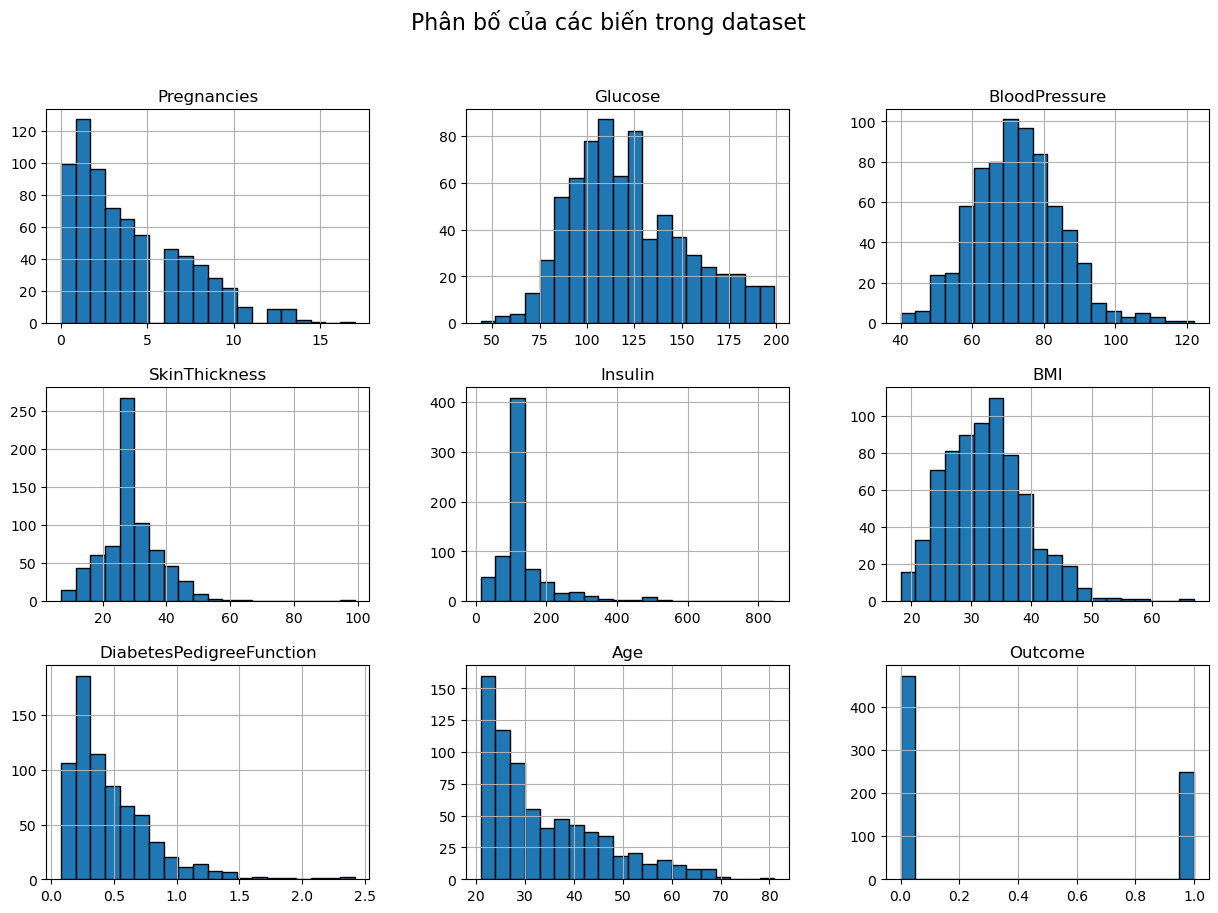

In [58]:
df_final.hist(bins=20, figsize=(15,10), edgecolor="black")
plt.suptitle("Phân bố của các biến trong dataset", fontsize=16)
plt.show()

### Phát hiện các giá trị ngoại lệ và bất thường

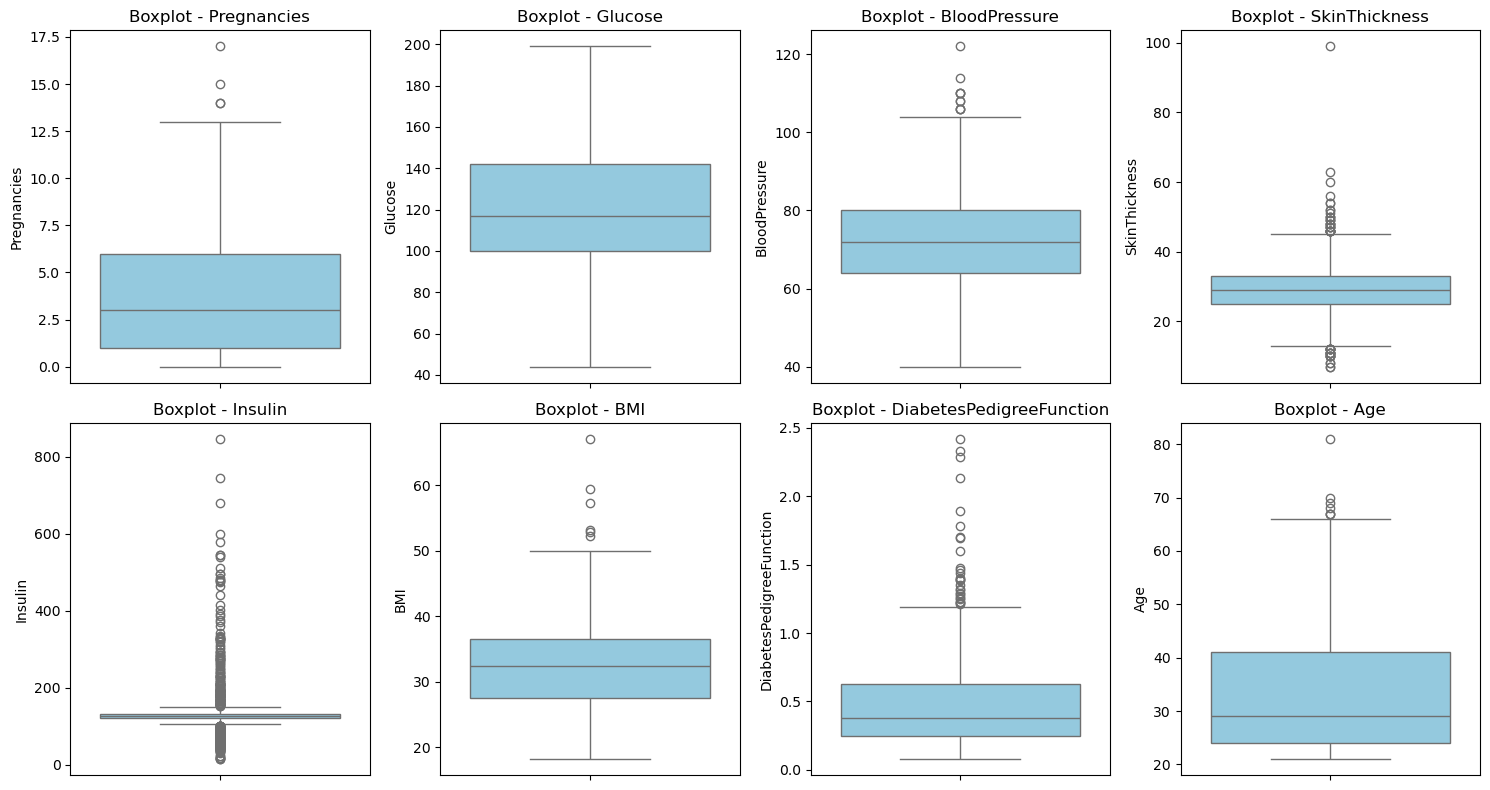

In [61]:
plt.figure(figsize=(15,8))
for i, col in enumerate(df_final.columns[:-1], 1):  # bỏ Outcome
    plt.subplot(2,4,i)
    sns.boxplot(y=df_final[col], color="skyblue")
    plt.title(f"Boxplot - {col}")
plt.tight_layout()
plt.show()

## PHÂN TÍCH BIẾN MỤC TIÊU

### Tỷ lệ mắc bệnh đái tháo đường

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3084790761.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outcome", data=df_final, palette="Set2")


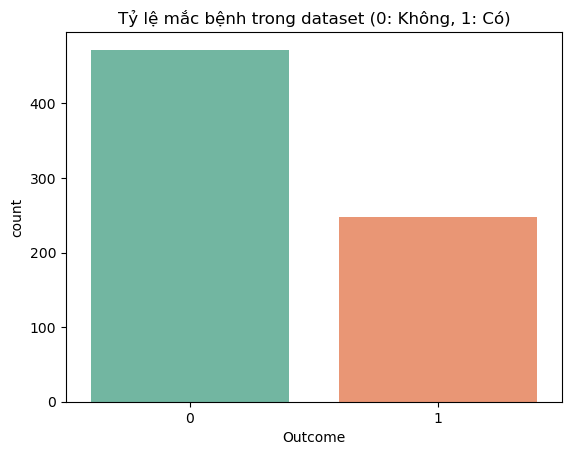

Outcome
0    0.655556
1    0.344444
Name: proportion, dtype: float64


In [62]:
sns.countplot(x="Outcome", data=df_final, palette="Set2")
plt.title("Tỷ lệ mắc bệnh trong dataset (0: Không, 1: Có)")
plt.show()

print(df_final["Outcome"].value_counts(normalize=True))

### Đặc điểm nhóm bệnh nhân và nhóm khỏe mạnh

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3418431536.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final[col][df_final["Outcome"]==0], label="Không mắc", shade=True)
C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3418431536.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final[col][df_final["Outcome"]==1], label="Mắc", shade=True)
C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3418431536.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final[col][df_final["Outcome"]==0], label="Không mắc", shade=True)
C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3418431536.py:5: FutureWarning: 

`

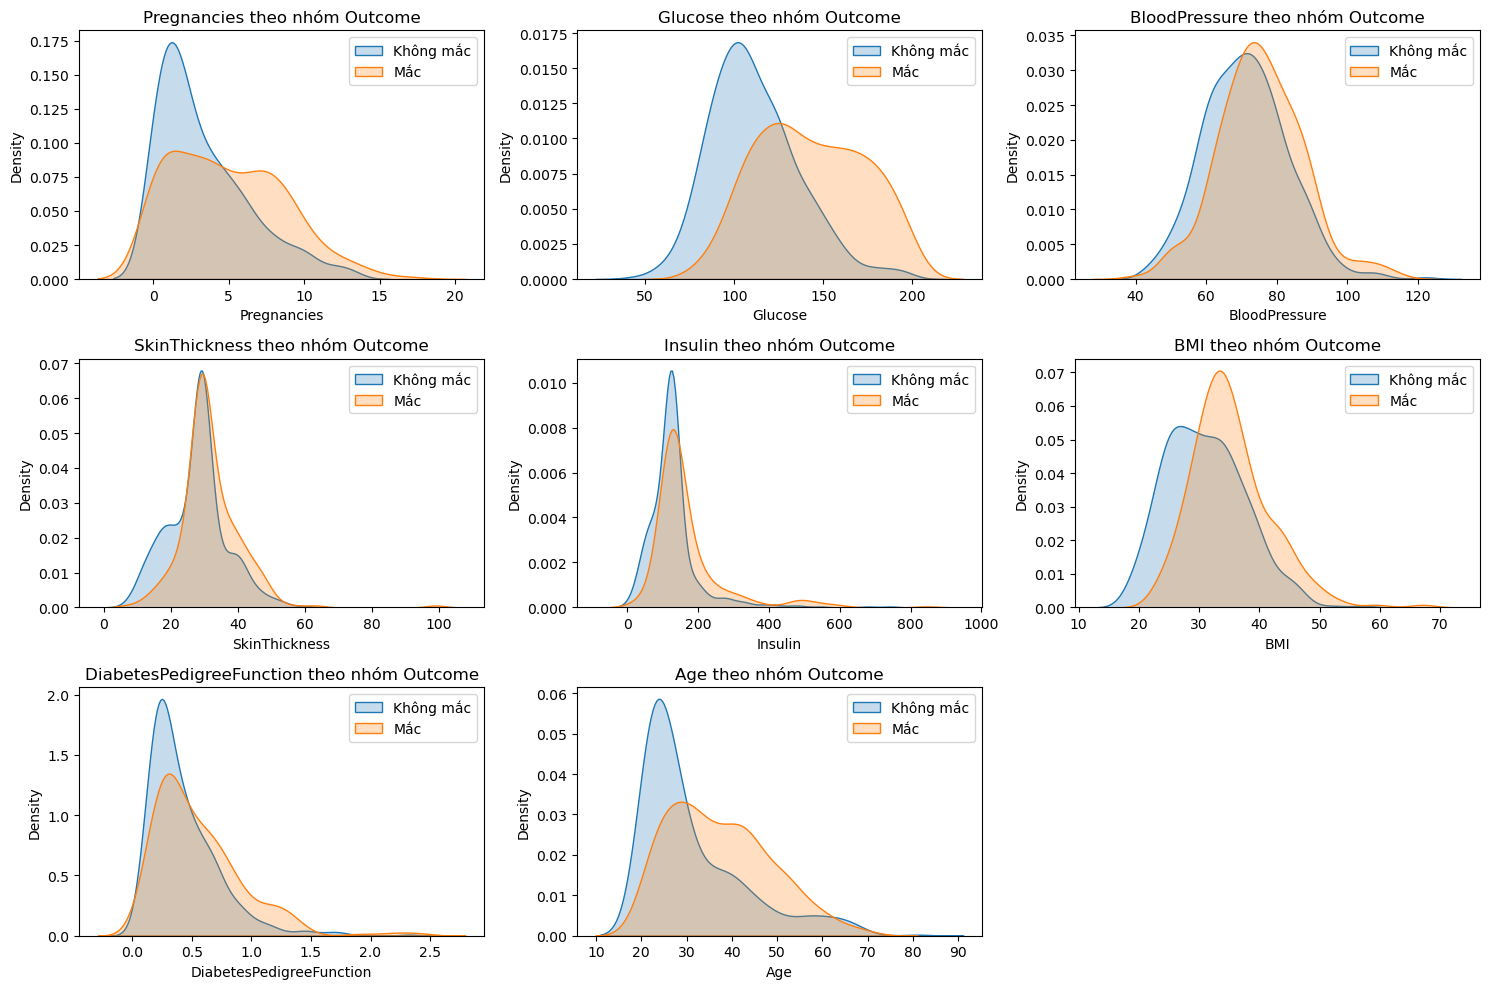

In [63]:
plt.figure(figsize=(15,10))
for i, col in enumerate(df_final.columns[:-1], 1):
    plt.subplot(3,3,i)
    sns.kdeplot(df_final[col][df_final["Outcome"]==0], label="Không mắc", shade=True)
    sns.kdeplot(df_final[col][df_final["Outcome"]==1], label="Mắc", shade=True)
    plt.title(f"{col} theo nhóm Outcome")
    plt.legend()
plt.tight_layout()
plt.show()

## PHÂN TÍCH THEO NHÓM TUỔI

### Phân bố bệnh theo độ tuổi

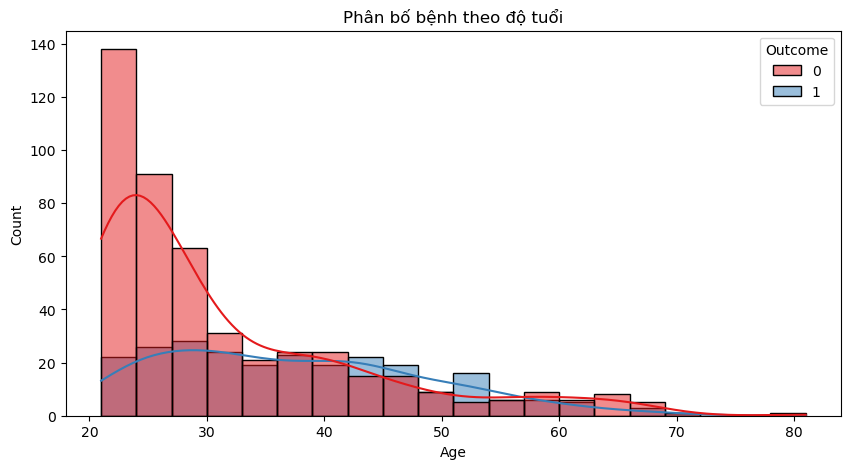

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_final, x="Age", hue="Outcome", bins=20, kde=True, palette="Set1")
plt.title("Phân bố bệnh theo độ tuổi")
plt.show()

### Các chỉ số sinh lý thay đổi theo tuổi

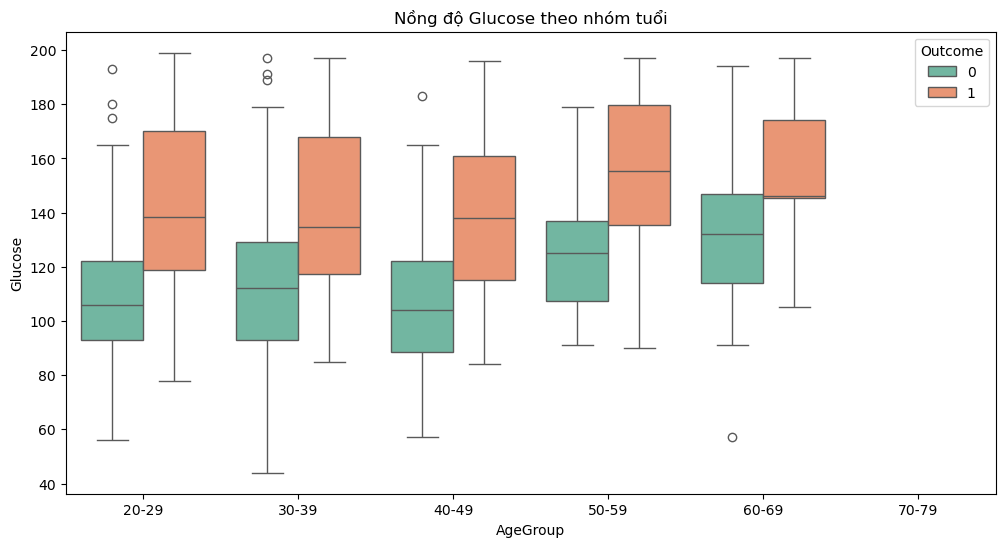

In [65]:
df_final["AgeGroup"] = pd.cut(df_final["Age"], bins=[20,30,40,50,60,70,80], labels=["20-29","30-39","40-49","50-59","60-69","70-79"])
plt.figure(figsize=(12,6))
sns.boxplot(x="AgeGroup", y="Glucose", hue="Outcome", data=df_final, palette="Set2")
plt.title("Nồng độ Glucose theo nhóm tuổi")
plt.show()

### Yếu tố nguy cơ ở từng nhóm tuổi

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\205234324.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_outcome = df_final.groupby("AgeGroup")["Outcome"].mean()


AgeGroup
20-29    0.206718
30-39    0.476190
40-49    0.564815
50-59    0.566038
60-69    0.291667
70-79         NaN
Name: Outcome, dtype: float64


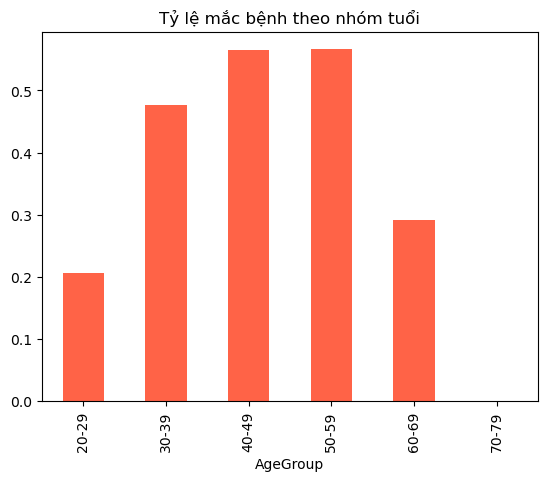

In [66]:
age_outcome = df_final.groupby("AgeGroup")["Outcome"].mean()
print(age_outcome)
age_outcome.plot(kind="bar", color="tomato", title="Tỷ lệ mắc bệnh theo nhóm tuổi")
plt.show()

## PHÂN TÍCH THEO CHỈ SỐ BMI

### Phân loại BMI và tỷ lệ mắc bệnh

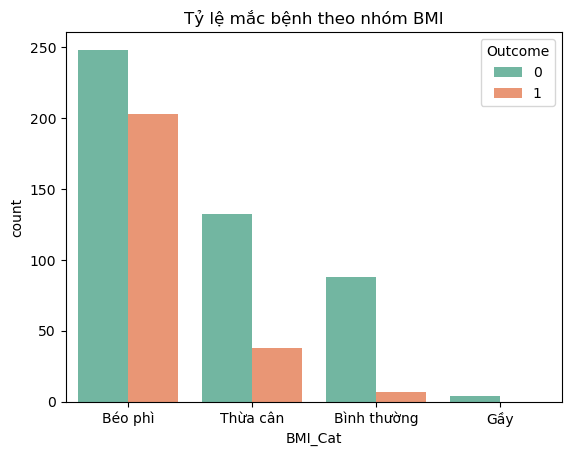

In [67]:
def bmi_category(bmi):
    if bmi < 18.5: return "Gầy"
    elif bmi < 25: return "Bình thường"
    elif bmi < 30: return "Thừa cân"
    else: return "Béo phì"

df_final["BMI_Cat"] = df_final["BMI"].apply(bmi_category)

sns.countplot(x="BMI_Cat", hue="Outcome", data=df_final, palette="Set2")
plt.title("Tỷ lệ mắc bệnh theo nhóm BMI")
plt.show()

### Mối quan hệ giữa béo phì và đái tháo đường

In [68]:
pd.crosstab(df_final["BMI_Cat"], df_final["Outcome"], normalize="index")

Outcome,0,1
BMI_Cat,,
Béo phì,0.549889,0.450111
Bình thường,0.926316,0.073684
Gầy,1.000000,0.000000
Thừa cân,0.776471,0.223529


### BMI kết hợp với các yếu tố khác

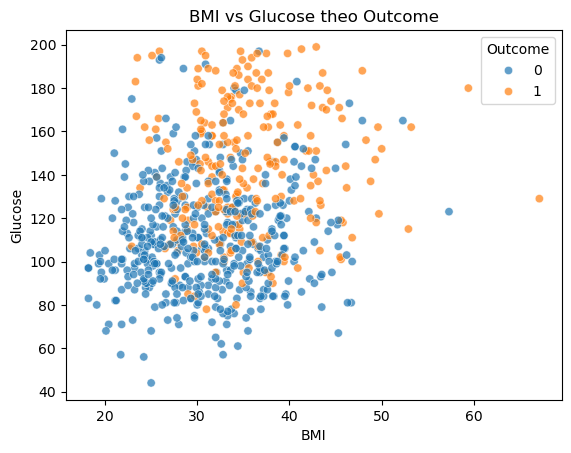

In [69]:
sns.scatterplot(x="BMI", y="Glucose", hue="Outcome", data=df_final, alpha=0.7)
plt.title("BMI vs Glucose theo Outcome")
plt.show()

## PHÂN TÍCH GLUCOSE VÀ INSULIN

### Phân bố nồng độ glucose

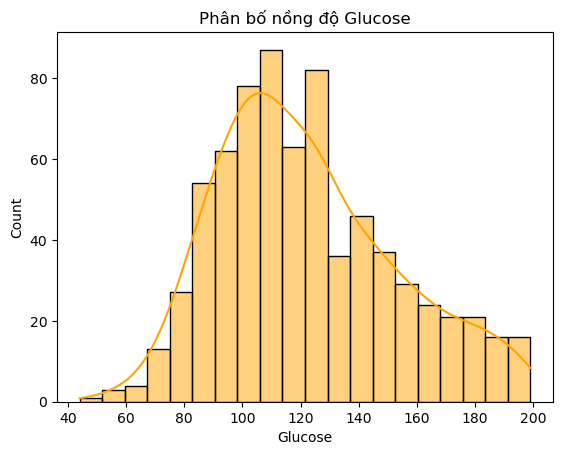

In [70]:
sns.histplot(df_final["Glucose"], bins=20, kde=True, color="orange")
plt.title("Phân bố nồng độ Glucose")
plt.show()

### Mối quan hệ glucose-insulin

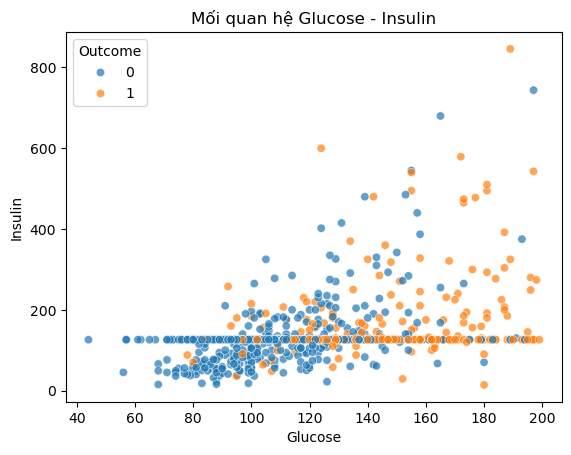

In [71]:
sns.scatterplot(x="Glucose", y="Insulin", hue="Outcome", data=df_final, alpha=0.7)
plt.title("Mối quan hệ Glucose - Insulin")
plt.show()

### Ngưỡng glucose trong chẩn đoán

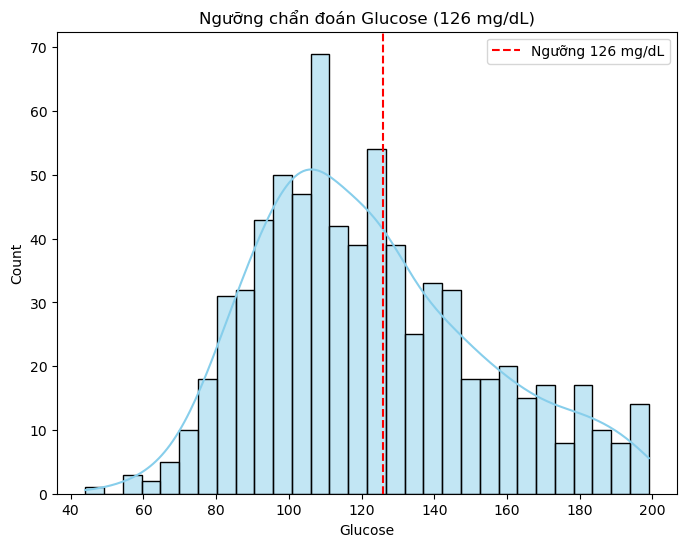

In [72]:
# WHO & ADA: ≥126 mg/dL là tiểu đường
plt.figure(figsize=(8,6))
sns.histplot(df_final["Glucose"], bins=30, kde=True, color="skyblue")
plt.axvline(126, color="red", linestyle="--", label="Ngưỡng 126 mg/dL")
plt.title("Ngưỡng chẩn đoán Glucose (126 mg/dL)")
plt.legend()
plt.show()

## PHÂN TÍCH YẾU TỐ DI TRUYỀN

### Hàm phả hệ đái tháo đường

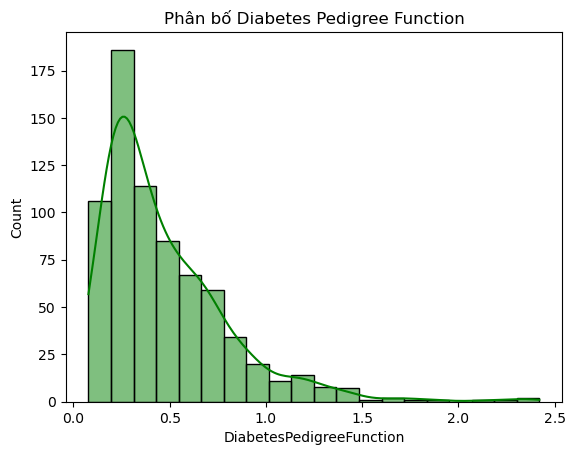

In [73]:
sns.histplot(df_final["DiabetesPedigreeFunction"], bins=20, kde=True, color="green")
plt.title("Phân bố Diabetes Pedigree Function")
plt.show()

### Tác động của yếu tố di truyền

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\1704867496.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="DiabetesPedigreeFunction", data=df_final, palette="Set2")


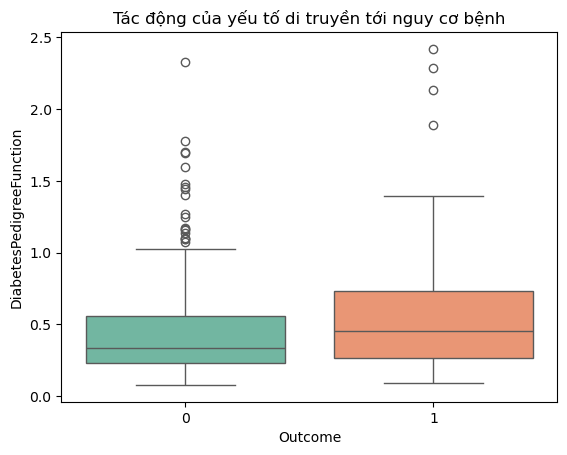

In [74]:
sns.boxplot(x="Outcome", y="DiabetesPedigreeFunction", data=df_final, palette="Set2")
plt.title("Tác động của yếu tố di truyền tới nguy cơ bệnh")
plt.show()

### Kết hợp yếu tố di truyền với các yếu tố khác

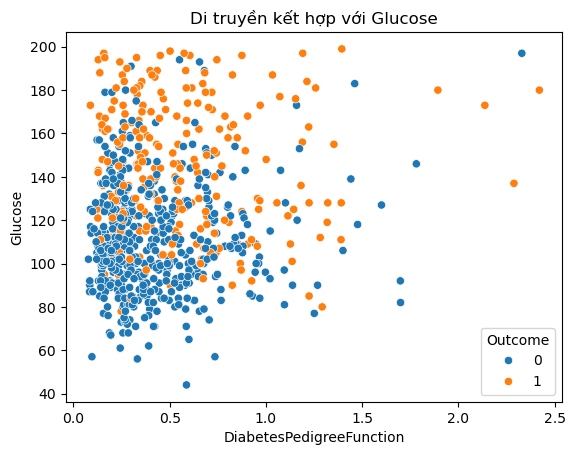

In [76]:
sns.scatterplot(x="DiabetesPedigreeFunction", y="Glucose", hue="Outcome", data=df_final)
plt.title("Di truyền kết hợp với Glucose")
plt.show()

## PHÂN TÍCH THEO SỐ LẦN CÓ THAI

### Mối quan hệ giữa thai kỳ và đái tháo đường

C:\Users\boeot\AppData\Local\Temp\ipykernel_10376\3080267763.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="Pregnancies", data=df_final, palette="Set2")


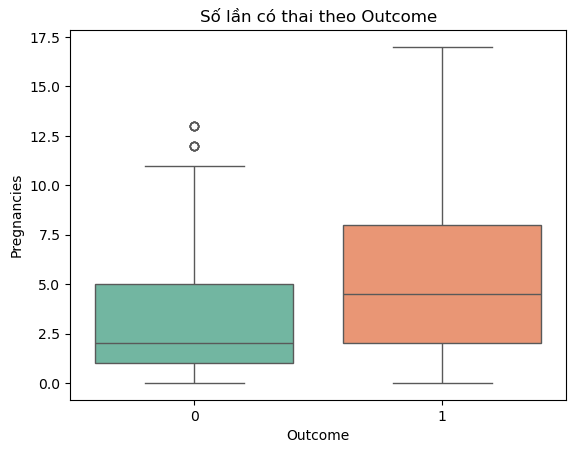

In [77]:
sns.boxplot(x="Outcome", y="Pregnancies", data=df_final, palette="Set2")
plt.title("Số lần có thai theo Outcome")
plt.show()

### Đái tháo đường thai kỳ

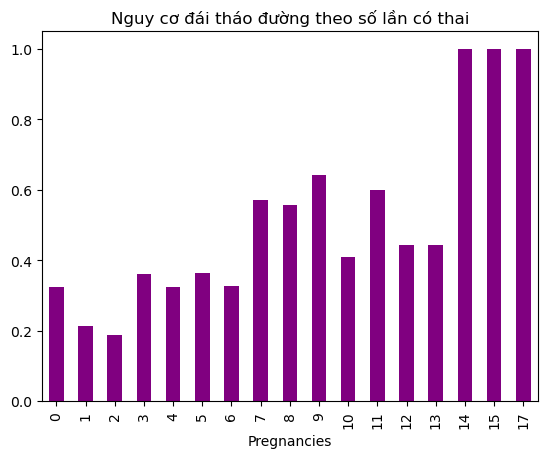

In [82]:
preg_outcome = df_final[df_final["Pregnancies"]>=0].groupby("Pregnancies")["Outcome"].mean()
preg_outcome.plot(kind="bar", color="purple", title="Nguy cơ đái tháo đường theo số lần có thai")
plt.show()